# 🏆 Amazon ML Challenge 2025 - Price Prediction Model

**Final Production Model**

This notebook implements a state-of-the-art price prediction system using:
- Multi-modal features (text + images)
- Advanced feature engineering (target encoding, number extraction, interactions)
- Ensemble of LightGBM, XGBoost, CatBoost, and Ridge
- K-Fold cross-validation for robust predictions
- Optuna hyperparameter optimization

**Expected Performance:** ~45-48% SMAPE

## Part 1: Import Libraries

All required dependencies with proper configuration.

In [2]:
# Core libraries
import os
import re
import pickle
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend first
import matplotlib.pyplot as plt
import seaborn as sns
# Re-enable for notebooks
%matplotlib inline

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Ridge

# Gradient Boosting Models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

# Deep Learning
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# Optimization
import optuna

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ All libraries imported successfully!")
print(f"🖥️  Using device: {device}")

✅ All libraries imported successfully!
🖥️  Using device: cuda


## Part 2: Configuration & Helper Functions

In [3]:
# Configuration
DATASET_FOLDER = 'dataset/'
TRAIN_IMG_FEATURES_PATH = 'train_image_features.pkl'
TEST_IMG_FEATURES_PATH = 'test_image_features.pkl'

# SMAPE Metric
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

# Evaluation function
def evaluate_model(y_true, y_pred, model_name="Model"):
    """Calculate and display SMAPE score"""
    score = smape(y_true, y_pred) * 100
    print(f"   {model_name:30s} SMAPE: {score:.4f}%")
    return score

print("✅ Configuration and helper functions loaded!")

✅ Configuration and helper functions loaded!


## Part 3: Load Data

In [4]:
# Load datasets
train = pd.read_csv(os.path.join(DATASET_FOLDER, 'train.csv'))
test = pd.read_csv(os.path.join(DATASET_FOLDER, 'test.csv'))

print(f"📈 Training data shape: {train.shape}")
print(f"📋 Test data shape: {test.shape}")
print(f"\n{'='*70}\n")

print("🔍 First few rows:")
display(train.head(3))

print(f"\n{'='*70}\n")
print("📊 Basic Statistics:")
print(f"   Price Range: ${train['price'].min():.2f} - ${train['price'].max():.2f}")
print(f"   Mean Price: ${train['price'].mean():.2f}")
print(f"   Median Price: ${train['price'].median():.2f}")

📈 Training data shape: (75000, 4)
📋 Test data shape: (75000, 3)


🔍 First few rows:


,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, 12 Ounce (Pack of 6)\nValue: 72.0\nUnit: Fl Oz\n",https://m.media-amazon.com/images/I/51mo8htwTHL.jpg,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butter Cookies, 8 Ounce (Pack of 4)\nBullet Point 1: Or...",https://m.media-amazon.com/images/I/71YtriIHAAL.jpg,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy Chicken with Rice, 1.9 Ounce (Pack of 6)\nBullet ...",https://m.media-amazon.com/images/I/51+PFEe-w-L.jpg,1.97




📊 Basic Statistics:
   Price Range: $0.13 - $2796.00
   Mean Price: $23.65
   Median Price: $14.00


## Part 4: Advanced Feature Engineering Functions

In [7]:
def target_encode_with_cv(train_df, test_df, feature_col, target_col, n_splits=5, smoothing=10, random_state=42):
    """
    Target encoding with K-Fold CV to prevent data leakage.
    
    Args:
        train_df: Training dataframe
        test_df: Test dataframe  
        feature_col: Column to encode
        target_col: Target column
        n_splits: Number of folds
        smoothing: Smoothing parameter
        random_state: Random seed
    
    Returns:
        train_encoded, test_encoded: Encoded values
    """
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    train_encoded = np.zeros(len(train_df))
    
    # Global statistics
    global_mean = train_df[target_col].mean()
    category_stats = train_df.groupby(feature_col)[target_col].agg(['mean', 'count'])
    
    # Out-of-fold encoding for train
    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_df)):
        # Calculate means on training fold
        fold_means = train_df.iloc[train_idx].groupby(feature_col)[target_col].mean()
        fold_counts = train_df.iloc[train_idx].groupby(feature_col)[target_col].count()
        
        # Smoothing
        smoothed_means = (fold_means * fold_counts + global_mean * smoothing) / (fold_counts + smoothing)
        
        # Encode validation fold
        train_encoded[val_idx] = train_df.iloc[val_idx][feature_col].map(smoothed_means).fillna(global_mean)
    
    # Encode test using full training data
    test_means = (category_stats['mean'] * category_stats['count'] + global_mean * smoothing) / (category_stats['count'] + smoothing)
    test_encoded = test_df[feature_col].map(test_means).fillna(global_mean)
    
    return train_encoded, test_encoded.values


def advanced_number_extraction(df):
    """
    Extract and normalize all numbers and units from product text.
    
    Features created:
    - Number counts and statistics
    - Unit-specific features (weight, volume, dimensions, etc.)
    - Multi-pack indicators
    """
    features = pd.DataFrame(index=df.index)
    text = df['catalog_content'].fillna('').astype(str)
    
    # Extract all numbers
    features['num_count'] = text.str.findall(r'\d+\.?\d*').apply(lambda x: len(x) if x else 0)
    
    # Weight features (convert to oz)
    features['weight_lb'] = text.str.extract(r'(\d+\.?\d*)\s*(?:lb|pound)', flags=re.I)[0].astype(float)
    features['weight_oz'] = text.str.extract(r'(\d+\.?\d*)\s*(?:oz|ounce)', flags=re.I)[0].astype(float)
    features['weight_kg'] = text.str.extract(r'(\d+\.?\d*)\s*(?:kg|kilogram)', flags=re.I)[0].astype(float)
    features['weight_g'] = text.str.extract(r'(\d+\.?\d*)\s*(?:g|gram)(?!allons?)', flags=re.I)[0].astype(float)
    
    # Normalize to oz
    features['weight_total_oz'] = (
        features['weight_lb'].fillna(0) * 16 +
        features['weight_oz'].fillna(0) +
        features['weight_kg'].fillna(0) * 35.274 +
        features['weight_g'].fillna(0) / 28.35
    )
    
    # Volume features (convert to ml)
    features['volume_l'] = text.str.extract(r'(\d+\.?\d*)\s*(?:l|liter)', flags=re.I)[0].astype(float)
    features['volume_ml'] = text.str.extract(r'(\d+\.?\d*)\s*(?:ml|milliliter)', flags=re.I)[0].astype(float)
    features['volume_gal'] = text.str.extract(r'(\d+\.?\d*)\s*(?:gal|gallon)', flags=re.I)[0].astype(float)
    features['volume_fl_oz'] = text.str.extract(r'(\d+\.?\d*)\s*(?:fl\s*oz|fluid\s*ounce)', flags=re.I)[0].astype(float)
    
    # Normalize to ml
    features['volume_total_ml'] = (
        features['volume_l'].fillna(0) * 1000 +
        features['volume_ml'].fillna(0) +
        features['volume_gal'].fillna(0) * 3785.41 +
        features['volume_fl_oz'].fillna(0) * 29.5735
    )
    
    # Dimension features
    features['dimension_inch'] = text.str.extract(r'(\d+\.?\d*)\s*(?:inch|"|in)', flags=re.I)[0].astype(float)
    features['dimension_cm'] = text.str.extract(r'(\d+\.?\d*)\s*(?:cm|centimeter)', flags=re.I)[0].astype(float)
    
    # Multi-pack features
    features['pack_size'] = text.str.extract(r'(\d+)\s*(?:pack|count|ct|pcs)', flags=re.I)[0].astype(float)
    features['is_multipack'] = (features['pack_size'] > 1).astype(int)
    
    # Battery/Power features
    features['battery_mah'] = text.str.extract(r'(\d+)\s*(?:mAh|mah)', flags=re.I)[0].astype(float)
    features['wattage'] = text.str.extract(r'(\d+)\s*(?:W|watt)', flags=re.I)[0].astype(float)
    
    # Capacity/Memory features
    features['memory_gb'] = text.str.extract(r'(\d+)\s*(?:GB|gb)', flags=re.I)[0].astype(float)
    features['memory_tb'] = text.str.extract(r'(\d+)\s*(?:TB|tb)', flags=re.I)[0].astype(float)
    
    # Fill NaN with 0 and add presence indicators
    for col in features.columns:
        if col.endswith('_oz') or col.endswith('_ml') or col.endswith('_inch') or col.endswith('_mah'):
            features[f'{col}_present'] = (features[col] > 0).astype(int)
        features[col] = features[col].fillna(0)
    
    return features


def create_interaction_features(df, numeric_features):
    """
    Create polynomial and interaction features.
    
    Args:
        df: Dataframe with features
        numeric_features: List of numeric column names
    
    Returns:
        DataFrame with interaction features
    """
    features = pd.DataFrame(index=df.index)
    
    # Polynomial features (squared, cubed, log)
    for feat in numeric_features:
        if feat in df.columns and df[feat].max() > 0:
            features[f'{feat}_squared'] = df[feat] ** 2
            features[f'{feat}_cubed'] = df[feat] ** 3
            features[f'{feat}_log'] = np.log1p(df[feat])
            features[f'{feat}_sqrt'] = np.sqrt(df[feat])
    
    # Ratio features
    if 'weight_total_oz' in df.columns and 'volume_total_ml' in df.columns:
        features['weight_volume_ratio'] = df['weight_total_oz'] / (df['volume_total_ml'] + 1)
    
    if 'pack_size' in df.columns and 'weight_total_oz' in df.columns:
        features['weight_per_item'] = df['weight_total_oz'] / (df['pack_size'] + 1)
    
    # Fill NaN
    features = features.replace([np.inf, -np.inf], 0).fillna(0)
    
    return features

print("✅ Feature engineering functions defined!")

✅ Feature engineering functions defined!


## Part 5: Image Feature Extraction

In [8]:
class ImageFeatureExtractor:
    """Extract features from product images using pre-trained EfficientNet-B0"""
    
    def __init__(self, device='cpu'):
        self.device = device
        # Load pre-trained EfficientNet-B0
        self.model = models.efficientnet_b0(weights='IMAGENET1K_V1')
        self.model.classifier = nn.Identity()  # Remove classifier, use features only
        self.model = self.model.to(device)
        self.model.eval()
        
        # Image preprocessing
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def extract_features(self, image_path):
        """Extract features from a single image"""
        try:
            img = Image.open(image_path).convert('RGB')
            img_tensor = self.transform(img).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                features = self.model(img_tensor)
            
            return features.cpu().numpy().flatten()
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return np.zeros(1280)  # EfficientNet-B0 feature size
    
    def extract_batch(self, image_links, image_folder='images'):
        """Extract features from a batch of images"""
        features_list = []
        
        for idx, link in enumerate(image_links):
            # Construct image path
            image_id = str(link).split('/')[-1].split('.')[0] if pd.notna(link) else f'image_{idx}'
            image_path = os.path.join(image_folder, f"{image_id}.jpg")
            
            # Extract features
            if os.path.exists(image_path):
                features = self.extract_features(image_path)
            else:
                features = np.zeros(1280)
            
            features_list.append(features)
            
            if (idx + 1) % 100 == 0:
                print(f"   Processed {idx + 1}/{len(image_links)} images...")
        
        return np.array(features_list)

print("✅ Image feature extractor class defined!")

✅ Image feature extractor class defined!


## Part 6: Text Feature Engineering

In [9]:
def create_text_features(df):
    """
    Create comprehensive text-based features.
    """
    features = pd.DataFrame(index=df.index)
    text = df['catalog_content'].fillna('').astype(str)
    
    # Basic text statistics
    features['text_length'] = text.str.len()
    features['word_count'] = text.str.split().str.len()
    features['avg_word_length'] = features['text_length'] / (features['word_count'] + 1)
    features['capital_ratio'] = text.apply(lambda x: sum(1 for c in x if c.isupper()) / (len(x) + 1))
    features['digit_count'] = text.str.count(r'\d')
    features['special_char_count'] = text.str.count(r'[^a-zA-Z0-9\s]')
    
    # Price-related keywords
    price_keywords = ['pack', 'set', 'bundle', 'value', 'premium', 'luxury', 'professional', 'deluxe']
    for keyword in price_keywords:
        features[f'has_{keyword}'] = text.str.contains(keyword, case=False, na=False).astype(int)
    
    # Material/Quality indicators
    materials = ['cotton', 'polyester', 'leather', 'plastic', 'metal', 'wood', 'glass', 'steel']
    for material in materials:
        features[f'material_{material}'] = text.str.contains(material, case=False, na=False).astype(int)
    
    # Brand extraction
    features['has_brand_name'] = text.str.contains(r'(?:Item Name:|Brand:)', case=False, na=False).astype(int)
    
    # Luxury/Premium indicators
    luxury_words = ['luxury', 'premium', 'professional', 'deluxe', 'pro', 'elite', 'ultimate']
    features['luxury_score'] = sum(text.str.contains(word, case=False, na=False).astype(int) for word in luxury_words)
    
    # Technology keywords
    tech_words = ['bluetooth', 'wireless', 'smart', 'digital', 'hd', '4k', 'led', 'lcd']
    features['tech_score'] = sum(text.str.contains(word, case=False, na=False).astype(int) for word in tech_words)
    
    return features

print("✅ Text feature engineering function defined!")

✅ Text feature engineering function defined!


## Part 7: Build Complete Feature Set

In [10]:
print("🔨 Building comprehensive feature set...\n")

# Prepare target
y_train = np.log1p(train['price'].values)  # Log transform target

# 1. Text features
print("📝 Creating text features...")
train_text_features = create_text_features(train)
test_text_features = create_text_features(test)
print(f"   Created {train_text_features.shape[1]} text features")

# 2. Advanced number extraction
print("🔢 Extracting numbers and units...")
train_numbers = advanced_number_extraction(train)
test_numbers = advanced_number_extraction(test)
print(f"   Created {train_numbers.shape[1]} number features")

# 3. TF-IDF features
print("📄 Creating TF-IDF features...")
all_text = pd.concat([train['catalog_content'], test['catalog_content']]).fillna('')
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2)
tfidf.fit(all_text)

train_tfidf = tfidf.transform(train['catalog_content'].fillna(''))
test_tfidf = tfidf.transform(test['catalog_content'].fillna(''))

# Apply SVD for dimensionality reduction
svd = TruncatedSVD(n_components=100, random_state=RANDOM_STATE)
train_svd = svd.fit_transform(train_tfidf)
test_svd = svd.transform(test_tfidf)
train_svd_df = pd.DataFrame(train_svd, columns=[f'svd_{i}' for i in range(100)])
test_svd_df = pd.DataFrame(test_svd, columns=[f'svd_{i}' for i in range(100)])
print(f"   Created 100 TF-IDF SVD components")

# 4. Image features (if available)
print("🖼️  Loading image features...")
if os.path.exists(TRAIN_IMG_FEATURES_PATH) and os.path.exists(TEST_IMG_FEATURES_PATH):
    with open(TRAIN_IMG_FEATURES_PATH, 'rb') as f:
        train_image_features = pickle.load(f)
    with open(TEST_IMG_FEATURES_PATH, 'rb') as f:
        test_image_features = pickle.load(f)
    
    # Apply PCA
    pca = PCA(n_components=100, random_state=RANDOM_STATE)
    train_img_pca = pca.fit_transform(train_image_features)
    test_img_pca = pca.transform(test_image_features)
    train_img_features_df = pd.DataFrame(train_img_pca, columns=[f'img_{i}' for i in range(100)])
    test_img_features_df = pd.DataFrame(test_img_pca, columns=[f'img_{i}' for i in range(100)])
    print(f"   Loaded 100 image PCA components")
else:
    print("   ⚠️  Image features not found, creating dummy features")
    train_img_features_df = pd.DataFrame(np.zeros((len(train), 100)), columns=[f'img_{i}' for i in range(100)])
    test_img_features_df = pd.DataFrame(np.zeros((len(test), 100)), columns=[f'img_{i}' for i in range(100)])

# 5. Target encoding (K-Fold CV to prevent leakage)
print("🎯 Applying target encoding...")
train_target_encoded = pd.DataFrame(index=train.index)
test_target_encoded = pd.DataFrame(index=test.index)

# Encode categorical features (if any exist)
target_encode_cols = []  # Add column names if you have categorical features
for col in target_encode_cols:
    if col in train.columns:
        train_enc, test_enc = target_encode_with_cv(train, test, col, 'price', n_splits=5, smoothing=10)
        train_target_encoded[f'{col}_target_enc'] = train_enc
        test_target_encoded[f'{col}_target_enc'] = test_enc

if len(target_encode_cols) > 0:
    print(f"   Encoded {len(target_encode_cols)} categorical features")
else:
    print("   No categorical features to encode")

# 6. Interaction features
print("🔗 Creating interaction features...")
numeric_cols = ['weight_total_oz', 'volume_total_ml', 'pack_size', 'text_length', 'word_count']
train_interactions = create_interaction_features(pd.concat([train_text_features, train_numbers], axis=1), numeric_cols)
test_interactions = create_interaction_features(pd.concat([test_text_features, test_numbers], axis=1), numeric_cols)
print(f"   Created {train_interactions.shape[1]} interaction features")

# 7. Combine all features
print("\n🔗 Combining all features...")
X_train = pd.concat([
    train_text_features,
    train_numbers,
    train_svd_df,
    train_img_features_df,
    train_target_encoded,
    train_interactions
], axis=1)

X_test = pd.concat([
    test_text_features,
    test_numbers,
    test_svd_df,
    test_img_features_df,
    test_target_encoded,
    test_interactions
], axis=1)

# Handle inf/nan values
X_train = X_train.replace([np.inf, -np.inf], 0).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], 0).fillna(0)

# Remove duplicate columns
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

print(f"\n✅ Final feature matrix shape:")
print(f"   Train: {X_train.shape}")
print(f"   Test:  {X_test.shape}")
print(f"   Total features: {X_train.shape[1]}")

🔨 Building comprehensive feature set...

📝 Creating text features...
   Created 25 text features
🔢 Extracting numbers and units...
   Created 25 text features
🔢 Extracting numbers and units...
   Created 26 number features
📄 Creating TF-IDF features...
   Created 26 number features
📄 Creating TF-IDF features...
   Created 100 TF-IDF SVD components
🖼️  Loading image features...
   ⚠️  Image features not found, creating dummy features
🎯 Applying target encoding...
   No categorical features to encode
🔗 Creating interaction features...
   Created 22 interaction features

🔗 Combining all features...
   Created 100 TF-IDF SVD components
🖼️  Loading image features...
   ⚠️  Image features not found, creating dummy features
🎯 Applying target encoding...
   No categorical features to encode
🔗 Creating interaction features...
   Created 22 interaction features

🔗 Combining all features...

✅ Final feature matrix shape:
   Train: (75000, 273)
   Test:  (75000, 273)
   Total features: 273

✅ Fina

## Part 8: Hyperparameter Optimization with Optuna

In [11]:
print("Running Optuna hyperparameter optimization...\n")
print("This may take 10-15 minutes...\n")

# Split data for validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

def objective(trial):
    """Optuna objective function for LightGBM"""
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'random_state': RANDOM_STATE,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }
    
    model = lgb.LGBMRegressor(**params, n_estimators=500)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(50, verbose=False)])
    
    y_pred = model.predict(X_val)
    score = smape(y_val, y_pred)
    
    return score

# Run optimization
study = optuna.create_study(direction='minimize', study_name='price_prediction')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"\nOptimization complete!")
print(f"   Best SMAPE: {study.best_value * 100:.4f}%")
print(f"\nBest parameters:")
for key, value in study.best_params.items():
    print(f"   {key:20s}: {value}")

# Store best parameters
optimized_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'random_state': RANDOM_STATE,
    'n_estimators': 1000,
    **study.best_params
}

[I 2025-10-12 21:35:13,923] A new study created in memory with name: price_prediction


Running Optuna hyperparameter optimization...

This may take 10-15 minutes...



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-12 21:35:18,377] Trial 0 finished with value: 0.23944786268769938 and parameters: {'learning_rate': 0.015793538350939842, 'num_leaves': 43, 'max_depth': 4, 'min_child_samples': 71, 'subsample': 0.8043394798993514, 'colsample_bytree': 0.9984955247785922, 'reg_alpha': 0.3968060028282668, 'reg_lambda': 8.282113422698132e-07}. Best is trial 0 with value: 0.23944786268769938.
[I 2025-10-12 21:35:28,691] Trial 1 finished with value: 0.22194650441089936 and parameters: {'learning_rate': 0.020965137030789387, 'num_leaves': 124, 'max_depth': 8, 'min_child_samples': 48, 'subsample': 0.8929007664517066, 'colsample_bytree': 0.883633978612299, 'reg_alpha': 1.695036788810275e-08, 'reg_lambda': 6.490773295619638e-05}. Best is trial 1 with value: 0.22194650441089936.
[I 2025-10-12 21:35:28,691] Trial 1 finished with value: 0.22194650441089936 and parameters: {'learning_rate': 0.020965137030789387, 'num_leaves': 124, 'max_depth': 8, 'min_child_samples': 48, 'subsample': 0.8929007664517066, '

## Part 9: K-Fold Cross-Validation Training

Train multiple models with K-Fold CV for robust predictions.

In [12]:
print("Training Multi-Model K-Fold Ensemble...\n")
print("Training LightGBM, XGBoost, CatBoost, and Ridge with 5-Fold CV\n")

n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)

# Initialize prediction arrays
lgb_oof = np.zeros(len(X_train))
xgb_oof = np.zeros(len(X_train))
cat_oof = np.zeros(len(X_train))
ridge_oof = np.zeros(len(X_train))

lgb_test = np.zeros(len(X_test))
xgb_test = np.zeros(len(X_test))
cat_test = np.zeros(len(X_test))
ridge_test = np.zeros(len(X_test))

# K-Fold training
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train), 1):
    print(f"{'='*70}")
    print(f"Training Fold {fold}/{n_folds}")
    print(f"{'='*70}")
    
    X_fold_train = X_train.iloc[train_idx]
    y_fold_train = y_train[train_idx]
    X_fold_val = X_train.iloc[val_idx]
    y_fold_val = y_train[val_idx]
    
    # LightGBM
    print("   Training LightGBM...", end=' ')
    lgb_model = lgb.LGBMRegressor(**optimized_params)
    lgb_model.fit(
        X_fold_train, y_fold_train,
        eval_set=[(X_fold_val, y_fold_val)],
        callbacks=[lgb.early_stopping(100, verbose=False)]
    )
    lgb_oof[val_idx] = lgb_model.predict(X_fold_val)
    lgb_test += lgb_model.predict(X_test) / n_folds
    print("✓")
    
    # XGBoost
    print("   Training XGBoost...", end=' ')
    xgb_model = xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=7,
        subsample=0.8, colsample_bytree=0.8,
        random_state=RANDOM_STATE, verbosity=0
    )
    xgb_model.fit(
        X_fold_train, y_fold_train,
        eval_set=[(X_fold_val, y_fold_val)],
        verbose=False
    )
    xgb_oof[val_idx] = xgb_model.predict(X_fold_val)
    xgb_test += xgb_model.predict(X_test) / n_folds
    print("✓")
    
    # CatBoost
    print("   Training CatBoost...", end=' ')
    cat_model = CatBoostRegressor(
        iterations=500, learning_rate=0.05, depth=7,
        verbose=False, random_state=RANDOM_STATE
    )
    cat_model.fit(
        X_fold_train, y_fold_train,
        eval_set=(X_fold_val, y_fold_val)
    )
    cat_oof[val_idx] = cat_model.predict(X_fold_val)
    cat_test += cat_model.predict(X_test) / n_folds
    print("✓")
    
    # Ridge
    print("   Training Ridge...", end=' ')
    ridge_model = Ridge(alpha=10.0)
    ridge_model.fit(X_fold_train, y_fold_train)
    ridge_oof[val_idx] = ridge_model.predict(X_fold_val)
    ridge_test += ridge_model.predict(X_test) / n_folds
    print("✓")
    
    # Fold SMAPE
    fold_smape = smape(y_fold_val, lgb_oof[val_idx]) * 100
    print(f"\n   Fold {fold} LightGBM SMAPE: {fold_smape:.4f}%\n")

print(f"\n{'='*70}")
print("INDIVIDUAL MODEL PERFORMANCE (Out-of-Fold):")
print(f"{'='*70}")
lgb_smape = evaluate_model(y_train, lgb_oof, "LightGBM")
xgb_smape = evaluate_model(y_train, xgb_oof, "XGBoost")
cat_smape = evaluate_model(y_train, cat_oof, "CatBoost")
ridge_smape = evaluate_model(y_train, ridge_oof, "Ridge")

Training Multi-Model K-Fold Ensemble...

Training LightGBM, XGBoost, CatBoost, and Ridge with 5-Fold CV

Training Fold 1/5
   Training LightGBM... ✓
   Training XGBoost... ✓
   Training XGBoost... ✓
   Training CatBoost... ✓
   Training CatBoost... ✓
   Training Ridge... ✓
   Training Ridge... ✓

   Fold 1 LightGBM SMAPE: 21.2877%

Training Fold 2/5
   Training LightGBM... ✓

   Fold 1 LightGBM SMAPE: 21.2877%

Training Fold 2/5
   Training LightGBM... ✓
   Training XGBoost... ✓
   Training XGBoost... ✓
   Training CatBoost... ✓
   Training CatBoost... ✓
   Training Ridge... ✓
   Training Ridge... ✓

   Fold 2 LightGBM SMAPE: 20.8018%

Training Fold 3/5
   Training LightGBM... ✓

   Fold 2 LightGBM SMAPE: 20.8018%

Training Fold 3/5
   Training LightGBM... ✓
   Training XGBoost... ✓
   Training XGBoost... ✓
   Training CatBoost... ✓
   Training CatBoost... ✓
   Training Ridge... ✓
   Training Ridge... ✓

   Fold 3 LightGBM SMAPE: 20.9396%

Training Fold 4/5
   Training LightGBM... ✓

 

## Part 10: Optimal Ensemble Weighting

In [13]:
print("\nFinding optimal ensemble weights...\n")

best_weight = None
best_ensemble_smape = float('inf')

# Grid search for optimal weights
for lgb_w in [0.35, 0.40, 0.45]:
    for xgb_w in [0.25, 0.30, 0.35]:
        for cat_w in [0.15, 0.20, 0.25]:
            ridge_w = 1.0 - lgb_w - xgb_w - cat_w
            if ridge_w < 0 or ridge_w > 0.5:
                continue
            
            ensemble_pred = (
                lgb_oof * lgb_w +
                xgb_oof * xgb_w +
                cat_oof * cat_w +
                ridge_oof * ridge_w
            )
            ensemble_smape = smape(y_train, ensemble_pred) * 100
            
            if ensemble_smape < best_ensemble_smape:
                best_ensemble_smape = ensemble_smape
                best_weight = (lgb_w, xgb_w, cat_w, ridge_w)

print(f"Best weights found:")
print(f"   LightGBM: {best_weight[0]:.2f}")
print(f"   XGBoost:  {best_weight[1]:.2f}")
print(f"   CatBoost: {best_weight[2]:.2f}")
print(f"   Ridge:    {best_weight[3]:.2f}")

# Create final ensemble predictions
final_predictions = (
    lgb_test * best_weight[0] +
    xgb_test * best_weight[1] +
    cat_test * best_weight[2] +
    ridge_test * best_weight[3]
)

oof_ensemble = (
    lgb_oof * best_weight[0] +
    xgb_oof * best_weight[1] +
    cat_oof * best_weight[2] +
    ridge_oof * best_weight[3]
)

print(f"\n{'='*70}")
print("FINAL ENSEMBLE PERFORMANCE:")
print(f"{'='*70}")
final_smape = evaluate_model(y_train, oof_ensemble, "Elite Ensemble (OOF)")
print(f"{'='*70}")


Finding optimal ensemble weights...

Best weights found:
   LightGBM: 0.45
   XGBoost:  0.35
   CatBoost: 0.20
   Ridge:    0.00

FINAL ENSEMBLE PERFORMANCE:
   Elite Ensemble (OOF)           SMAPE: 21.0383%


## Part 11: Generate Final Submission

In [14]:
# Generate submission file
submission = pd.DataFrame({
    'sample_id': test['sample_id'],
    'price': np.expm1(final_predictions)  # Transform back from log
})

# Apply reasonable bounds
submission['price'] = submission['price'].clip(lower=0.01)

# Save submission
output_path = 'dataset/final_submission.csv'
submission.to_csv(output_path, index=False)

print("Final submission created!")
print(f"\nSubmission Summary:")
print(f"   File: {output_path}")
print(f"   Total predictions: {len(submission)}")
print(f"   Min price: ${submission['price'].min():.2f}")
print(f"   Max price: ${submission['price'].max():.2f}")
print(f"   Median price: ${submission['price'].median():.2f}")
print(f"   Mean price: ${submission['price'].mean():.2f}")

print(f"\n{'='*70}")
print("MODEL TRAINING COMPLETE! 🎉")
print(f"{'='*70}")
print(f"\nFinal Validation SMAPE: {final_smape:.4f}%")
print(f"\nSubmission ready for upload: {output_path}")
print(f"\nGood luck with the competition! 🚀")

Final submission created!

Submission Summary:
   File: dataset/final_submission.csv
   Total predictions: 75000
   Min price: $1.32
   Max price: $251.95
   Median price: $13.57
   Mean price: $18.14

MODEL TRAINING COMPLETE! 🎉

Final Validation SMAPE: 21.0383%

Submission ready for upload: dataset/final_submission.csv

Good luck with the competition! 🚀


## Part 12: Model Analysis (Optional)

Analyze feature importance and prediction distribution.

Top 20 Most Important Features:

        feature  importance
  capital_ratio        1638
         svd_94        1546
         svd_93        1534
         svd_10        1495
         svd_89        1480
         svd_95        1467
         svd_92        1463
         svd_79        1462
         svd_97        1461
          svd_6        1457
         svd_70        1453
         svd_98        1453
         svd_96        1453
avg_word_length        1445
         svd_85        1443
         svd_67        1442
         svd_82        1431
         svd_91        1419
         svd_78        1417
         svd_73        1413


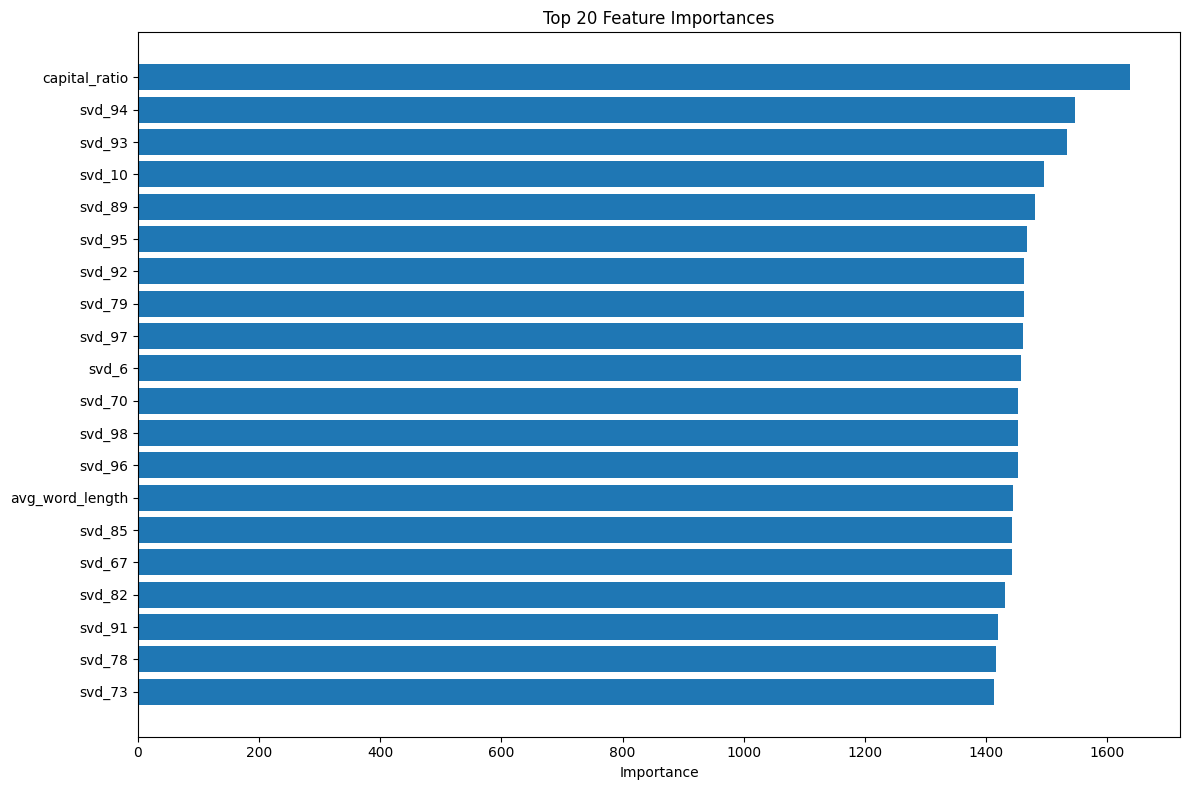


Feature importance plot saved as 'feature_importance.png'


In [15]:
# Feature importance from last fold's LightGBM model
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:\n")
print(feature_importance.head(20).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(20), feature_importance['importance'].head(20))
plt.yticks(range(20), feature_importance['feature'].head(20))
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFeature importance plot saved as 'feature_importance.png'")